<a href="https://colab.research.google.com/github/gelgel5633/self-study/blob/main/%ED%95%84%EC%82%AC/Sentiment_Analysis_on_Movie_Reviews%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필사 관련 사이트
- competition 명 : Sentiment Analysis on Movie Reviews
- competition 링크 : https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews
- notebook 필사 링크 : https://www.kaggle.com/code/sammir/end-to-end-nlp-eda-ml-with-sentiment-analysis/notebook

감성분석과 End to End (EDA + ML)

이 노트북에서 bag of words와 tf-idf의 텍스트 인코딩 방법과 로지스틱 회귀를 이용해서 text 분류를 수행할 것입니다.
우리의 task는 텍스트를 분류하여 감정 클래스를 결정하는 것입니다.
우리의 데이터셋에서는 0,1,2,3,4로 분류된 영화리뷰 데이터가 포함되어있는데, 0은 부정적, 1은 다소 부정적, 2는 중립, 3은 다소 긍정적, 4는 긍정입니다.

우리는 ML을 하기 전에 EDA를 수행합니다

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# nltk = natural language tool kit -> 자연어 처리를 위해 필요한 모듈. stopwords 를 흔하게 사용함
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# 문서의 단어(토큰)의 사용빈도를 담는 클래스
from nltk.probability import FreqDist
from nltk import ngrams

import string, re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings, os

In [6]:
plt.figure(figsize = (16,7))
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

<Figure size 1152x504 with 0 Axes>

### 데이터 로드

In [7]:
#os.walk를 사용하여 파일 탐색, for문으로 하위폴더를 탐색
for dirname, _, filenames in os.walk("../content/drive/MyDrive/transcription"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../content/drive/MyDrive/transcription/sampleSubmission.csv
../content/drive/MyDrive/transcription/test.tsv.zip
../content/drive/MyDrive/transcription/train.tsv.zip


In [8]:
train = pd.read_csv("/content/drive/MyDrive/transcription/train.tsv.zip", sep = '\t')
test = pd.read_csv("/content/drive/MyDrive/transcription/test.tsv.zip", sep="\t")

# Part1 EDA

In [9]:
train.shape, test.shape

((156060, 4), (66292, 3))

In [10]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [11]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [13]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [14]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


### 감성 설명

In [15]:
train["sentiment_class"] = train["Sentiment"].map({0:"negative", 1:"somewhat negative", 2:"neutral", 3:"somewhat positive", 4:"positive"})
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


### 구둣점 제거

In [16]:
def remove_punctuation(text):
    return "".join([t for t in text if t not in string.punctuation])

In [17]:
train["Phrase"] = train["Phrase"].apply(lambda x : remove_punctuation(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


In [18]:
# 위에서 import string 을 했음 -> 위의 함수는 아래에 출력된 문자를 제거하는 역할
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
# 문자열을 for 문으로 불러올 경우 한 글자씩 출력됨
new_test = "A series of "
for t in new_test:
    print(t)

A
 
s
e
r
i
e
s
 
o
f
 


### 2글자 미만인 문자 제거

In [20]:
def words_with_more_than_three_chars(text):
    return " ".join([t for t in text.split() if len(t) >3])

In [21]:
train["Phrase"] = train["Phrase"].apply(lambda x : words_with_more_than_three_chars(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage that what...,1,somewhat negative
1,2,1,series escapades demonstrating adage that what...,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


2글자 미만인줄 알았는데 노트북 작성하신 분은 4글자 이상만 남기셨음

### 불용어 제거

In [22]:
#이 구간을 실행하지 않으면 아래셀을 실행할 수 없음(코랩 내부에 stopwords를 설치하지 않은 것으로 보임)
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
stop_words = stopwords.words("english")
train["Phrase"] = train["Phrase"].apply(lambda x: " ".join([word for word in x.split() \
                                                            if word not in (stop_words)]))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative
1,2,1,series escapades demonstrating adage good goose,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


### 감성 카테고리 체크

In [24]:
train.groupby("Sentiment")["Sentiment"].count()

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

### 타겟 변수 시각화

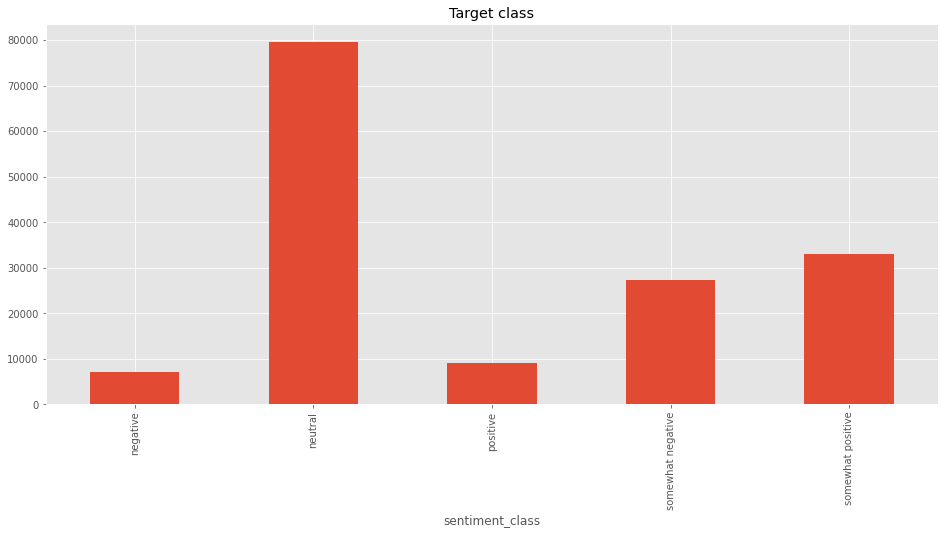

In [25]:
train.groupby("sentiment_class")["sentiment_class"].count().plot(kind = "bar", \
                                                                 title = "Target class", figsize=(16,7), grid = True)

### 각 클래스별 퍼센트 얻기

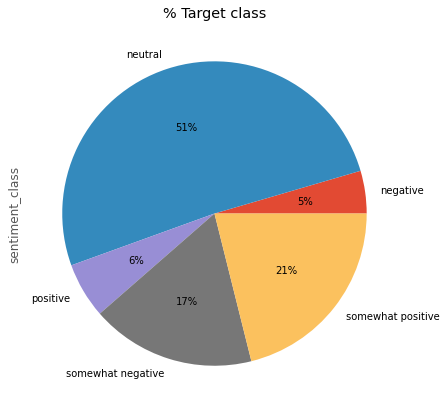

In [26]:
# autopct 인자 : 부채꼴 안에 표시될 숫자의 형식을 지정
# 해당 경우에는 소숫점 0번째 자리까지 출력으로 이해하면 됨
# 뒤에 %가 2개 붙은 것은 문자 %를 가리킴 -> 보통은 \% 로 표현하는데 예외사항???
# 링크 : https://wikidocs.net/13
((train.groupby("sentiment_class")["sentiment_class"].count()/train.shape[0]) * 100).plot(kind = "pie", \
                                    figsize = (7,7), title = "% Target class", autopct = "%1.0f%%")

### 구문 길이 추가

In [27]:
train["PhraseLength"] = train["Phrase"].apply(lambda x : len(x))

In [28]:
# ascending = 오름차순
train.sort_values(by="PhraseLength", ascending = False).head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength
54876,54877,2734,Filmmakers Dana JanklowiczMann Amir Mann area ...,3,somewhat positive,207
62992,62993,3189,addition sporting worst titles recent cinemati...,0,negative,200
26148,26149,1199,movie biggest shocks come seeing former nymphe...,1,somewhat negative,199
62500,62501,3162,While transgressive trappings especially frank...,1,somewhat negative,197
72577,72578,3708,Stephen Earnhart documentary decomposition hea...,1,somewhat negative,196


### 각 클래스별 구문 길이 분포

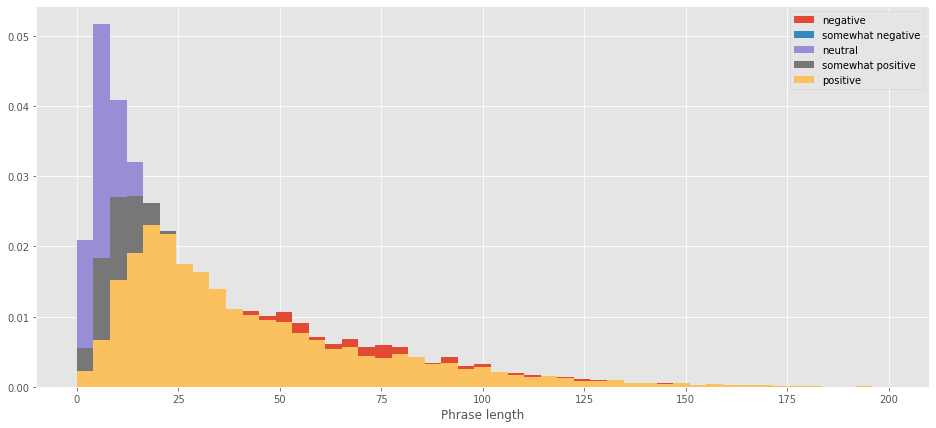

In [29]:
plt.figure(figsize = (16,7))
bins = np.linspace(0,200,50)
plt.hist(train[train["sentiment_class"] == "negative"]["PhraseLength"], bins = bins, density = True, \
         label = "negative")
plt.hist(train[train["sentiment_class"] == "somewhat negative"]["PhraseLength"], bins = bins, density = True, \
         label = "somewhat negative")
plt.hist(train[train["sentiment_class"] == "neutral"]["PhraseLength"], bins = bins, density = True, \
         label = "neutral")
plt.hist(train[train["sentiment_class"] == "somewhat positive"]["PhraseLength"], bins = bins, density = True, \
         label = "somewhat positive")
plt.hist(train[train["sentiment_class"] == "positive"]["PhraseLength"], bins = bins, density = True, \
         label = "positive")
plt.xlabel("Phrase length")
plt.legend()
plt.show()

### word cloud 와 일반 단어

In [30]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

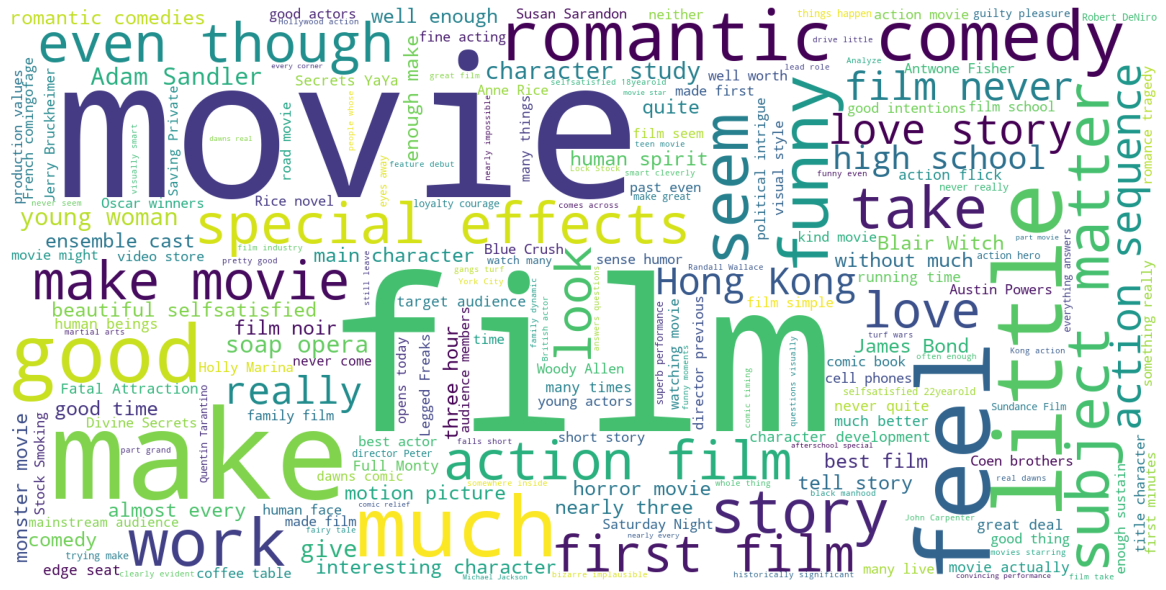

In [31]:
word_cloud_common_words = []
# iterrows : pandas dataframe에 사용, 각 행의 모든 컬럼의 값을 가져올 때 사용
# 참고 : https://cosmosproject.tistory.com/368
# 인덱스에 상관없이 첫 행부터 순차적으로 값을 가져옴
for index, row in train.iterrows():
    word_cloud_common_words.append((row["Phrase"]))
word_cloud_common_words

wordcloud = WordCloud(width = 1600, height = 800, background_color = "white", stopwords = stopwords, \
                       min_font_size= 5).generate("".join(word_cloud_common_words))

plt.figure(figsize = (16,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### 단어 빈도

In [32]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [33]:
text_list  = []
for index, row in train.iterrows():
    text_list.append((row["Phrase"]))
text_list

total_words = "".join(text_list)
total_words = word_tokenize(total_words)

In [34]:
freq_words = FreqDist(total_words)
# word_frequency 는 딕셔너리 형태로 저장됨
word_frequency = FreqDist(freq_words)

In [35]:
# 빈도수 상위 10 개 단어
print(word_frequency.most_common(10))

[('film', 3259), ('movie', 2892), ('like', 1968), ('story', 1204), ('much', 1085), ('good', 1069), ('even', 1041), ('characters', 994), ('little', 976), ('make', 838)]


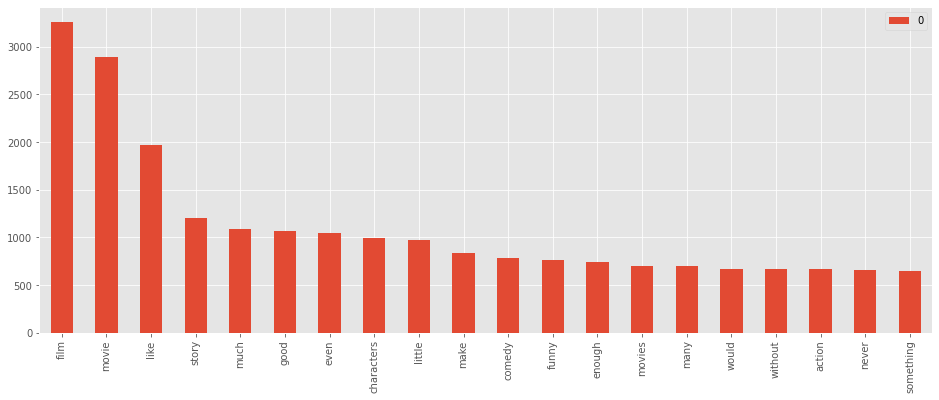

In [36]:
# 시각화
pd.DataFrame(word_frequency, index = [0]).T.sort_values(by=[0], ascending=False).head(20).plot(kind = "bar", \
                                                                        figsize = (16,6), grid = True)

### 부정 감성에서 일반적으로 사용되는 단어들

In [37]:
neg_text_list = []
for index, row in train[train["Sentiment"]==0].iterrows():
    neg_text_list.append((row["Phrase"]))
neg_text_list

neg_total_words = " ".join(neg_text_list)
neg_total_words = word_tokenize(neg_total_words)

neg_freq_words = FreqDist(neg_total_words)
neg_word_frequency = FreqDist(neg_freq_words)

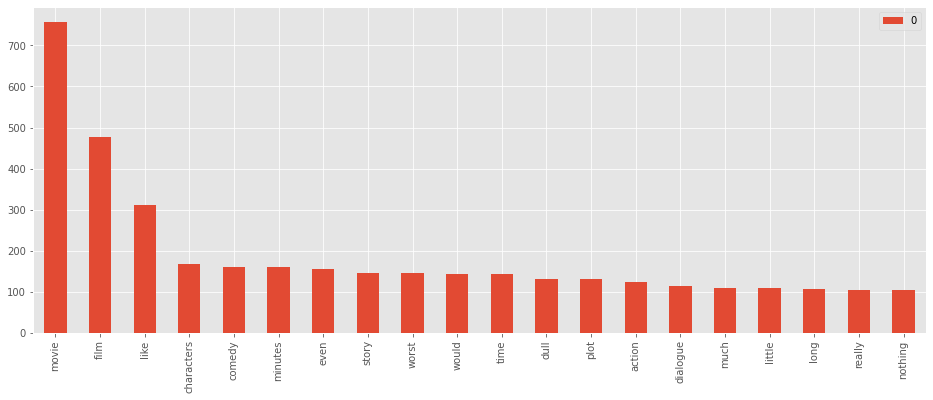

In [38]:
# 시각화
pd.DataFrame(neg_word_frequency, index = [0]).T.sort_values(by = [0], ascending=False).head(20).plot(kind="bar", \
                                                                figsize = (16,6), grid = True)

> - 위에서 index = [0] 의 의미는 인덱스를 0으로 설정한다는 뜻
- 설정하지 않을 경우 "If using all scalar values, you must pass an index" 에러 발생
- 해결법 : https://rfriend.tistory.com/482
- 해결법 요약 : 위에서처럼 index = [0] 
    - or 딕셔너리 value 값에 리스트를 씌워주기 
    - or pd.DataFrame.from_records([{키:밸류, ...}]) 사용 
    - or pd.DataFrame.fromdict([{키:밸류, ...}]) 사용

### 긍정 감성에서 일반적으로 사용하는 단어들

In [39]:
pos_text_list = []
for index, row in train[train["Sentiment"]==4].iterrows():
    pos_text_list.append((row["Phrase"]))
pos_text_list

pos_total_words = " ".join(pos_text_list)
pos_total_words = word_tokenize(pos_total_words)

pos_freq_words = FreqDist(pos_total_words)
pos_word_frequency = FreqDist(pos_freq_words)

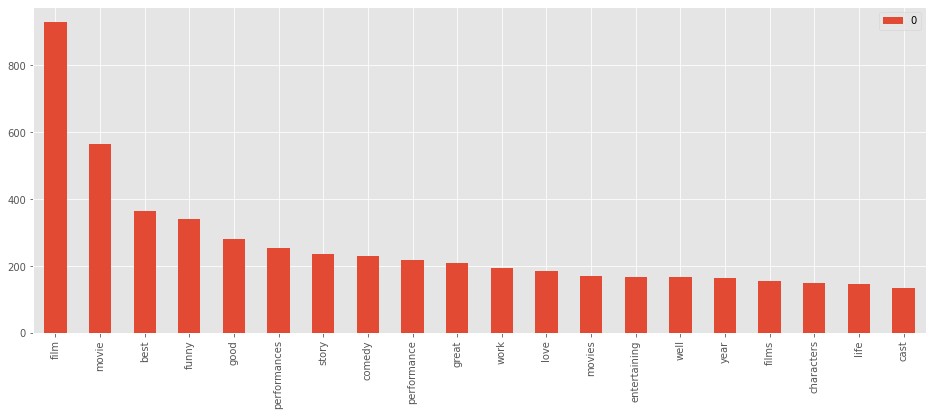

In [40]:
# 시각화
pd.DataFrame(pos_word_frequency, index = [0]).T.sort_values(by = [0], ascending=False).head(20) \
.plot(kind = "bar", figsize = (16,6), grid = True)

### 긍정 감성에서 일반적으로 사용되는 bigram
- bigram?
    - 띄어쓰기 하나로 분리된 집합을 의미
    - 예를들어 linear regression, decision Tree 등
    - trigram은 띄어쓰기 두 개로 분리된 집합
    - 예를들어 one hot encoding, i never die 등
    - unigram은 단어 하나를 지칭

In [41]:
text="Tom and Jerry love mickey. But mickey dont love Tom and Jerry. What a love mickey is getting from these two friends"

In [42]:
bigram_frequency = FreqDist(ngrams(word_tokenize(text), 3))
bigram_frequency.most_common()[0:5]

[(('Tom', 'and', 'Jerry'), 2),
 (('and', 'Jerry', 'love'), 1),
 (('Jerry', 'love', 'mickey'), 1),
 (('love', 'mickey', '.'), 1),
 (('mickey', '.', 'But'), 1)]

In [43]:
text_list=[]  
for index, row in train.iterrows(): 
    text_list.append((row['Phrase'])) 
text_list

total_words=' '.join(text_list)
total_words=word_tokenize(total_words)

freq_words=FreqDist(total_words)
word_frequency=FreqDist(ngrams(freq_words,2))
word_frequency.most_common()[0:5]

[(('film', 'movie'), 1),
 (('movie', 'like'), 1),
 (('like', 'story'), 1),
 (('story', 'good'), 1),
 (('good', 'characters'), 1)]

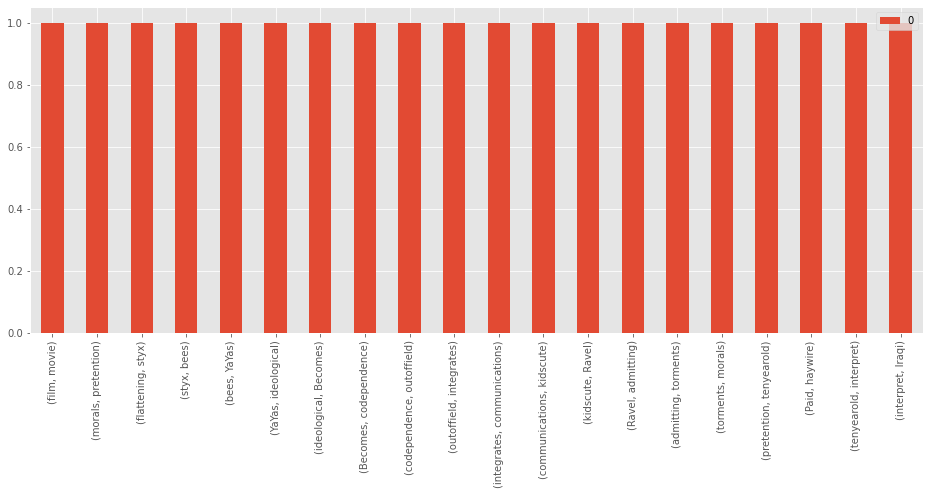

In [44]:
# 시각화
pd.DataFrame(word_frequency, index = [0]).T.sort_values(by = [0], ascending = False). \
    head(20).plot(kind = "bar", figsize = (16,6), grid = True)

# Part2 머신 러닝 모델링

### training data 준비
### CountVectorizer를 이용한 Bag of words 생성

In [45]:
train["tokenized_words"] = train["Phrase"].apply(lambda x: word_tokenize(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength,tokenized_words
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative,108,"[series, escapades, demonstrating, adage, good..."
1,2,1,series escapades demonstrating adage good goose,2,neutral,47,"[series, escapades, demonstrating, adage, good..."
2,3,1,series,2,neutral,6,[series]
3,4,1,,2,neutral,0,[]
4,5,1,series,2,neutral,6,[series]


In [46]:
count_vectorizer = CountVectorizer()
phrase_dtm =  count_vectorizer.fit_transform(train["Phrase"])

In [47]:
phrase_dtm.shape

(156060, 15746)

### training validation 세트를 70: 30 의 비율로 나눕니다

In [48]:
X_train,X_val,y_train,y_val=train_test_split(phrase_dtm,train['Sentiment'],test_size=0.3, random_state=38)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((109242, 15746), (109242,), (46818, 15746), (46818,))

### 로지스틱 회귀 모델 train

In [49]:
model=LogisticRegression()

In [50]:
model.fit(X_train,y_train)

LogisticRegression()

### 모델 성능 측정

In [51]:
accuracy_score(model.predict(X_val), y_val) * 100

63.75752915545303

### tf-idf를 위한 메모리 확보

In [52]:
del X_train
del X_val
del y_train
del y_val

### tf-idf로 데이터 준비

In [53]:
tfidf = TfidfVectorizer()
tfidf_dtm = tfidf.fit_transform(train["Phrase"])

In [54]:
X_train,X_val,y_train,y_val=train_test_split(tfidf_dtm,train['Sentiment'],test_size=0.3, random_state=38)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((109242, 15746), (109242,), (46818, 15746), (46818,))

In [55]:
tfidf_model=LogisticRegression()

In [56]:
tfidf_model.fit(X_train,y_train)

LogisticRegression()

In [57]:
accuracy_score(tfidf_model.predict(X_val), y_val) * 100

62.37985390234525

### 테스트 데이터에 대한 예측

In [58]:
print(tfidf_model.predict(X_val)[0:10])

[3 2 2 2 2 2 2 3 2 3]


### 새 데이터 예측 함수

In [59]:
def predict_new_text(text):
    tfidf_text = tfidf.transform([text])
    return tfidf_model.predict(tfidf_text)

In [60]:
predict_new_text("The movie is bad and sucks!")

array([0])

### 테스트 데이터 준비

In [61]:
test["Phrase"] = test["Phrase"].apply(lambda x:remove_punctuation(x))
test["Phrase"] = test["Phrase"].apply(lambda x: words_with_more_than_three_chars(x))
test["Phrase"] = test["Phrase"].apply(lambda x: " ".join([word for word in x.split() if word \
                                                          not in (stop_words)]))
test_dtm = tfidf.transform(test["Phrase"])

### 테스트 데이터에 대한 예측

In [62]:
test["Sentiment"] = tfidf_model.predict(test_dtm)
test.set_index = test["PhraseId"]
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,intermittently pleasing mostly routine effort,3
1,156062,8545,intermittently pleasing mostly routine effort,3
2,156063,8545,,2
3,156064,8545,intermittently pleasing mostly routine effort,3
4,156065,8545,intermittently pleasing mostly routine,3


In [63]:
# csv파일로 결과를 저장
#test.to_csv("Submission.csv", columns = ["PhraseId", "Sentiment"], index = False)